In [7]:
#                                              Top Instagram Influencers Data (Cleaned)
#import libaries
import os, sys, pandas as pd, numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction import FeatureHasher
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
from collections import Counter

In [8]:
# ---------- SETTINGS ----------
DATA_PATH = r"C:\Users\kriti\Downloads\top_insta_influencers_data.csv"   # change if needed
OUT_DIR = './project_outputs'
os.makedirs(OUT_DIR, exist_ok=True)
# ---------- 1. LOAD ----------
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Data file not found at {DATA_PATH}")
df = pd.read_csv(DATA_PATH, low_memory=False)
print("Loaded shape:", df.shape)
print("Columns:", df.columns.tolist())

Loaded shape: (200, 32)
Columns: ['rank', 'channel_info', 'influence_score', 'posts', 'followers', 'avg_likes', '60_day_eng_rate', 'new_post_avg_like', 'total_likes', 'country', 'avg_comments', 'engagement', 'engagement_rate_pct', 'engagement_rate_decimal', 'likes_per_post_from_total', 'likes_per_post', 'following', 'followers_following_ratio', 'log1p_followers', 'log1p_posts', 'log1p_total_likes', 'log1p_likes_per_post', 'caption_len', 'hashtag_count', 'mention_count', 'url_count', 'days_since_last_post', 'account_age_days', 'posts_per_day', 'posts_per_month', 'verified_binary', 'followers_times_engrate']


In [9]:
# ---------- 2. CLEAN COLUMN NAMES ----------
df.columns = [c.strip().lower().replace(' ', '_') for c in df.columns]

In [10]:
# ---------- 3. NUMERIC STRING CLEANUP ----------
def clean_numeric_strings(series):
    if series.dtype == object:
        s = series.str.replace(',', '', regex=False).str.replace('%','', regex=False).str.strip()
        s = s.replace({'': np.nan, 'nan': np.nan, 'none': np.nan})
        return pd.to_numeric(s, errors='coerce')
    return series

In [11]:
# Apply only when likely numeric (heuristic)
for col in df.columns:
    if df[col].dtype == object:
        sample = df[col].dropna().astype(str).head(200)
        if len(sample) > 0 and (sample.str.contains(r'\d').sum() > max(5, len(sample)*0.1)):
            df[col] = clean_numeric_strings(df[col])


In [12]:
# Apply only when likely numeric (heuristic)
for col in df.columns:
    if df[col].dtype == object:
        sample = df[col].dropna().astype(str).head(200)
        if len(sample) > 0 and (sample.str.contains(r'\d').sum() > max(5, len(sample)*0.1)):
            df[col] = clean_numeric_strings(df[col])


In [13]:
# ---------- 5. DROP rows with no followers ----------
df = df[df['followers'].notna() & (df['followers'] > 0)].reset_index(drop=True)
print("After drop missing/zero followers:", df.shape)

After drop missing/zero followers: (200, 32)


In [14]:
# ---------- 6. Feature engineering ----------
# log transforms
for c in ['followers','avg_likes','total_likes','influence_score']:
    if c in df.columns:
        df[c + '_log1p'] = np.log1p(df[c].clip(lower=0))

In [15]:
# follower quantile bin (4 bins)
df['follower_bin'] = pd.qcut(df['followers'], q=4, labels=['q1_small','q2','q3','q4_large'])

In [16]:
# text length if channel_info exists
if 'channel_info' in df.columns:
    df['channel_info_len'] = df['channel_info'].fillna('').astype(str).str.len()

In [17]:
# ---------- 7. Prepare feature lists ----------
# drop identifier-like fields from features if present
drop_like = []
for k in ['username','id','name','profile','channel_info']:
    if k in df.columns:
        drop_like.append(k)

target = 'engagement_rate_pct'
features = [c for c in df.columns if c not in drop_like + [target]]

In [18]:
# Separate numeric & categorical
num_features = df[features].select_dtypes(include=[np.number]).columns.tolist()
cat_features = df[features].select_dtypes(include=['object','category']).columns.tolist()

print("Numeric features:", num_features)
print("Categorical features:", cat_features)

Numeric features: ['rank', 'influence_score', 'posts', 'followers', 'avg_likes', '60_day_eng_rate', 'new_post_avg_like', 'total_likes', 'avg_comments', 'engagement', 'engagement_rate_decimal', 'likes_per_post_from_total', 'likes_per_post', 'following', 'followers_following_ratio', 'log1p_followers', 'log1p_posts', 'log1p_total_likes', 'log1p_likes_per_post', 'caption_len', 'hashtag_count', 'mention_count', 'url_count', 'days_since_last_post', 'account_age_days', 'posts_per_day', 'posts_per_month', 'verified_binary', 'followers_times_engrate', 'followers_log1p', 'avg_likes_log1p', 'total_likes_log1p', 'influence_score_log1p', 'channel_info_len']
Categorical features: ['country', 'follower_bin']


In [19]:
# ---------- 8. Efficient encoding for categorical features ----------
# For low-cardinality categorical use frequency encoding; for high-cardinality use hashing.
# Set threshold
HIGH_CARD_THR = 20

# Build transforms: numeric: median impute + scale
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

In [20]:
# We'll build a two-part preprocessor manually:
# - numeric pipeline applied
# - categorical features transformed to numeric using frequency encoding and hashing for high-card
def freq_encode(df_col):
    vc = df_col.fillna('unknown').astype(str).value_counts(normalize=True)
    return df_col.fillna('unknown').astype(str).map(vc).astype(float)

In [23]:
# Precompute encoded categorical columns into new DataFrame to keep pipeline simple & fast
for c in cat_features:
    # Convert to string first to avoid pandas categorical issues
    col_str = df[c].astype(str).replace('nan', 'unknown')
    n_unique = col_str.nunique(dropna=False)

    if n_unique <= HIGH_CARD_THR:
        cat_encoded[c + '_freq'] = freq_encode(col_str)
    else:
        # High-cardinality column -> hash encoding
        k = 8
        hasher = FeatureHasher(n_features=k, input_type='string')
        vals = col_str.tolist()
        hashed = hasher.transform([[v] for v in vals]).toarray()
        for i in range(k):
            cat_encoded[f"{c}_hash_{i}"] = hashed[:, i]



In [24]:
# Final modeling DataFrame
X_full = pd.concat([df[num_features].reset_index(drop=True), cat_encoded.reset_index(drop=True)], axis=1)
y_full = df[target].astype(float)

print("Modeling matrix shape:", X_full.shape)

Modeling matrix shape: (200, 43)


In [25]:
# ---------- 9. Train/test split ----------
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2, random_state=42)
print("Train/test shapes:", X_train.shape, X_test.shape)

Train/test shapes: (160, 43) (40, 43)


In [26]:
# ---------- 10. Build and run model ----------
model = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)

In [28]:
# We'll impute any remaining NaN in numeric features (should be few) using SimpleImputer
from sklearn.impute import SimpleImputer
imp = SimpleImputer(strategy='median')
X_train_imp = pd.DataFrame(imp.fit_transform(X_train),
                           index=X_train.index)
X_test_imp = pd.DataFrame(imp.transform(X_test),
                          index=X_test.index)


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['following' 'followers_following_ratio' 'caption_len' 'hashtag_count'
 'mention_count' 'url_count' 'days_since_last_post' 'account_age_days'
 'posts_per_day' 'posts_per_month']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['following' 'followers_following_ratio' 'caption_len' 'hashtag_count'
 'mention_count' 'url_count' 'days_since_last_post' 'account_age_days'
 'posts_per_day' 'posts_per_month']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


In [29]:
# scale numeric if desired - for random forest not necessary; keeping raw numeric usually fine
model.fit(X_train_imp, y_train)

RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42)

In [30]:
# CV RMSE (on training set)
cv_scores = cross_val_score(model, X_train_imp, y_train, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
print("CV RMSE (training):", -cv_scores.mean())

CV RMSE (training): 1.023856669601869


In [31]:
# ---------- 11. Evaluate on test ----------
y_pred = model.predict(X_test_imp)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Test RMSE: {rmse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")

Test RMSE: 0.2059, MAE: 0.1128, R2: 0.9931


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [32]:
# ---------- 12. Feature importances ----------
# RandomForest feature_importances_ align with X_train_imp columns
fi = pd.DataFrame({'feature': X_train_imp.columns, 'importance': model.feature_importances_})
fi = fi.sort_values('importance', ascending=False).reset_index(drop=True)

In [33]:
# ---------- 13. Save outputs for Power BI ----------
cleaned_path = os.path.join(OUT_DIR, 'cleaned_data.csv')
pred_path = os.path.join(OUT_DIR, 'model_predictions.csv')
summary_path = os.path.join(OUT_DIR, 'summary_metrics.csv')
featimp_path = os.path.join(OUT_DIR, 'feature_importance.csv')
model_path = os.path.join(OUT_DIR, 'best_model.pkl')

In [34]:
# Save cleaned dataset (original cols + engineered features)
df.to_csv(cleaned_path, index=False)

In [35]:
# Save predictions: attach original index info if you have an identifier, else include all modeling cols
pred_df = X_test_imp.copy()
pred_df[target + '_actual'] = y_test.values
pred_df[target + '_pred'] = y_pred
pred_df.to_csv(pred_path, index=False)

In [36]:
# Save summary metrics
pd.DataFrame([{'rmse': rmse, 'mae': mae, 'r2': r2, 'cv_rmse_mean': -cv_scores.mean()}]).to_csv(summary_path, index=False)
fi.to_csv(featimp_path, index=False)
joblib.dump({'model': model, 'imputer': imp, 'features': X_train_imp.columns.tolist()}, model_path)

print("Saved outputs to:", OUT_DIR)
print("Files:", os.listdir(OUT_DIR))

Saved outputs to: ./project_outputs
Files: ['best_model.pkl', 'cleaned_data.csv', 'feature_importance.csv', 'model_predictions.csv', 'summary_metrics.csv']


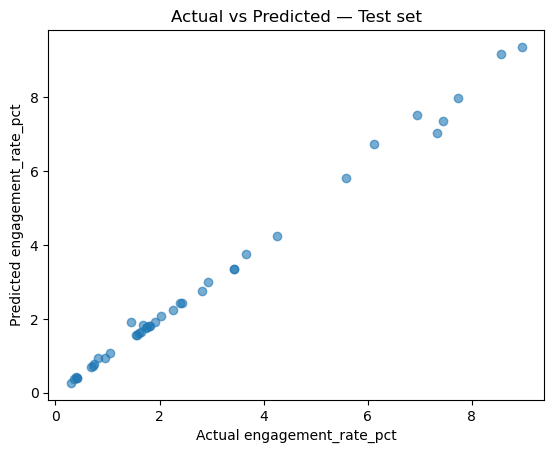

<Figure size 640x480 with 0 Axes>

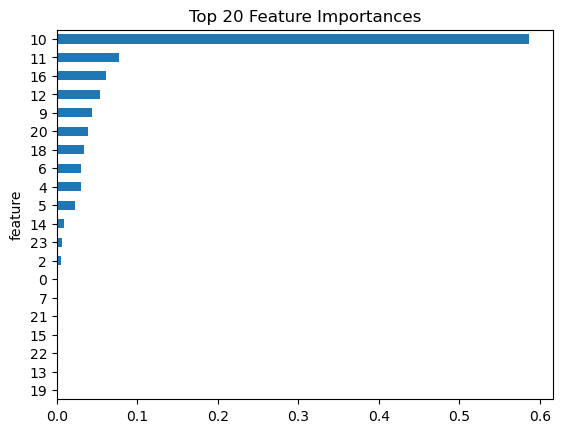

In [37]:
# ---------- 14. Quick plots ----------
plt.figure()
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel("Actual " + target)
plt.ylabel("Predicted " + target)
plt.title("Actual vs Predicted — Test set")
plt.show()

plt.figure()
fi.head(20).plot(kind='barh', x='feature', y='importance', legend=False)
plt.title("Top 20 Feature Importances")
plt.gca().invert_yaxis()
plt.show()

In [38]:
# ---------- 15. Print run summary ----------
print("\nRun complete. Files created:")
print(" - Cleaned dataset:", cleaned_path)
print(" - Predictions:", pred_path)
print(" - Summary metrics:", summary_path)
print(" - Feature importance:", featimp_path)
print(" - Model artifact:", model_path)

print("\nPower BI instruction: load 'cleaned_data.csv' + 'model_predictions.csv' + 'feature_importance.csv' (see next cell for detailed steps).")


Run complete. Files created:
 - Cleaned dataset: ./project_outputs\cleaned_data.csv
 - Predictions: ./project_outputs\model_predictions.csv
 - Summary metrics: ./project_outputs\summary_metrics.csv
 - Feature importance: ./project_outputs\feature_importance.csv
 - Model artifact: ./project_outputs\best_model.pkl

Power BI instruction: load 'cleaned_data.csv' + 'model_predictions.csv' + 'feature_importance.csv' (see next cell for detailed steps).


In [39]:
import os
print("File saved at:", os.path.abspath("cleaned_data.csv"))

File saved at: C:\Users\kriti\cleaned_data.csv
